In [1324]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [1325]:
X = pd.read_csv('train.csv')
y = X[['PassengerId', 'Transported']]
y = y.set_index('PassengerId')


In [1326]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2, stratify=y)
X_to_predict = pd.read_csv('test.csv')

In [1327]:
#Заполнение пустых значений
#Если человек был в криосне, то он не тратил денег, и наоборот, если человек не тратил денег, то он был в криосне
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
all_ixes = [X_train, X_test, X_to_predict]
def fillna_spendings_by_zeros(X):
    cryosleep_mask = (X['CryoSleep'] == True)
    X.loc[cryosleep_mask, spending_cols] = X.loc[cryosleep_mask, spending_cols].fillna(0)
def fillna_cryosleep(X):
    spending_mask = X[spending_cols].sum(axis=1)==0
    X.loc[spending_mask, 'CryoSleep'] = X.loc[spending_mask, 'CryoSleep'].fillna(True)
    X.loc[(spending_mask*-1+1).astype(bool), 'CryoSleep'] = X.loc[(spending_mask*-1+1).astype(bool), 'CryoSleep'].fillna(False)
#видим, что Cryosleep весь заполнен, и там где он == True, в тратах везде нули. Значит надо по фильтру Cryosleep==False заполнить медиану по тратам
spending_medians = X_train.loc[X['CryoSleep'] == False, spending_cols].median()###
def fillna_spendings_by_medians(X):
    for col in spending_cols:
        X[col] = X[col].fillna(spending_medians[col])
#Home_planet просто берем как моду(самая часто встречаемая величина)
home_planet_mode = X_train['HomePlanet'].mode()[0]
def fillna_home_planet(X):
    X['HomePlanet']  = X['HomePlanet'].fillna(home_planet_mode)
#VIP заплолняем False, т.к. их очень мало
def fillna_VIP(X):
    X['VIP'] = X['VIP'].fillna(False)
#Destination просто берем как моду(самая часто встречаемая величина)
destination_mode = X_train['Destination'].mode()[0]
def fillna_destination(X):
    X['Destination'] = X['Destination'].fillna(destination_mode)
#Age лучше заполнить как средний возраст по планетам
homeplanet_age = X_train.groupby('HomePlanet')['Age'].median()
def fillna_homeplanet_age(X):
    X['Age'] = X['Age'].fillna(X['HomePlanet'].map(homeplanet_age))
#Кабину сплитим, переименовываем и удаляем составляющую, отвечающую за номер кабины
def split_cabin(X):
    cabin_splitted = X['Cabin'].str.split('/', expand=True)
    cabin_splitted = cabin_splitted.rename(columns={0: 'Deck', 1: 'Cabinnum', 2: 'Side'})
    X = X.join(cabin_splitted)
    X.drop(columns='Cabinnum', inplace=True)
    return X

for X in all_ixes:
    fillna_spendings_by_zeros(X)
    fillna_cryosleep(X)
    fillna_spendings_by_medians(X)
    fillna_home_planet(X)
    fillna_VIP(X)
    fillna_destination(X)
    fillna_homeplanet_age(X)

X_train = split_cabin(X_train)
X_test = split_cabin(X_test)
X_to_predict = split_cabin(X_to_predict)









C:\Users\KBA116975\AppData\Local\Temp\ipykernel_21784\2776647184.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.loc[spending_mask, 'CryoSleep'] = X.loc[spending_mask, 'CryoSleep'].fillna(True)
C:\Users\KBA116975\AppData\Local\Temp\ipykernel_21784\2776647184.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.loc[(spending_mask*-1+1).astype(bool), 'CryoSleep'] = X.loc[(spending_mask*-1+1).astype(bool), 'CryoSleep'].fillna(False)
C:\Users\KBA116975\AppData\Local\Temp\ipykernel_21784\2776647184.py:23: FutureWarning: Downcasting object dtype array

In [1328]:
all_ixes = [X_train, X_test, X_to_predict] 
def fillna_cabin_param(X):
    X['Cabin'] = X['Cabin'].isnull().astype(int)
    X['Deck'] = X['Deck'].fillna('Unknown')
    X['Side'] = X['Side'].fillna('Unknown')
#Имя мы просто удаляем, нет титулов в имени. Можно извлечь длину имени, но делать этого мы не будем
def delete_name(X):
    X.drop(columns='Name', inplace=True)
#Создадим фичу по группе людей, надо будет сделать One-Hot
def passenger_group(X):
    X['group'] = X['PassengerId'].str.split('_').str[1]

for X in all_ixes:
    fillna_cabin_param(X)
    delete_name(X)
    passenger_group(X)
X_train.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Deck            0
Side            0
group           0
dtype: int64

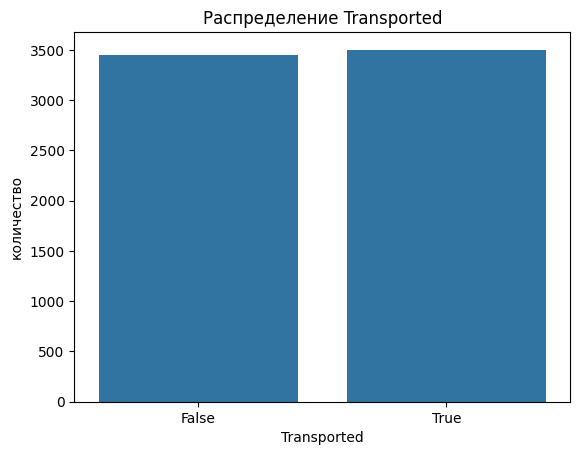

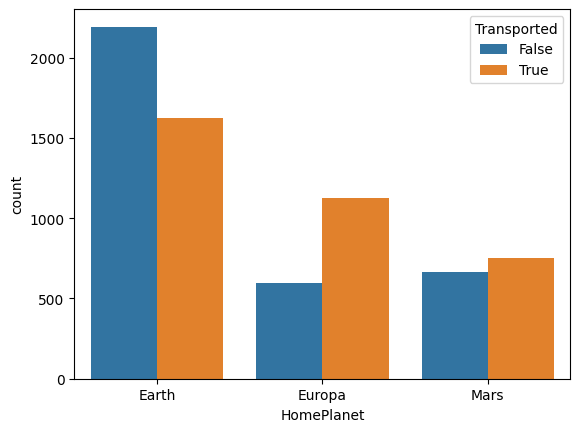

In [1329]:
#Распределение целевой переменной (Transported)
plt.subplot()
sns.countplot(data=X_train, x='Transported')
plt.title('Распределение Transported')
plt.xlabel('Transported')
plt.ylabel('количество')
plt.show()

#Распределение соотношения по HomePlanet
plt.subplot()
sns.countplot(data=X_train, x='HomePlanet', hue='Transported')
plt.show()

#Из графика видно, что OrdinalEncoder сюда не подойдет, по крайней мере для линейных моделейтак как зависимость выживания нелинейная, 
# зато подойдет OneHotEncoder, тем более, что признаков образуется не так много




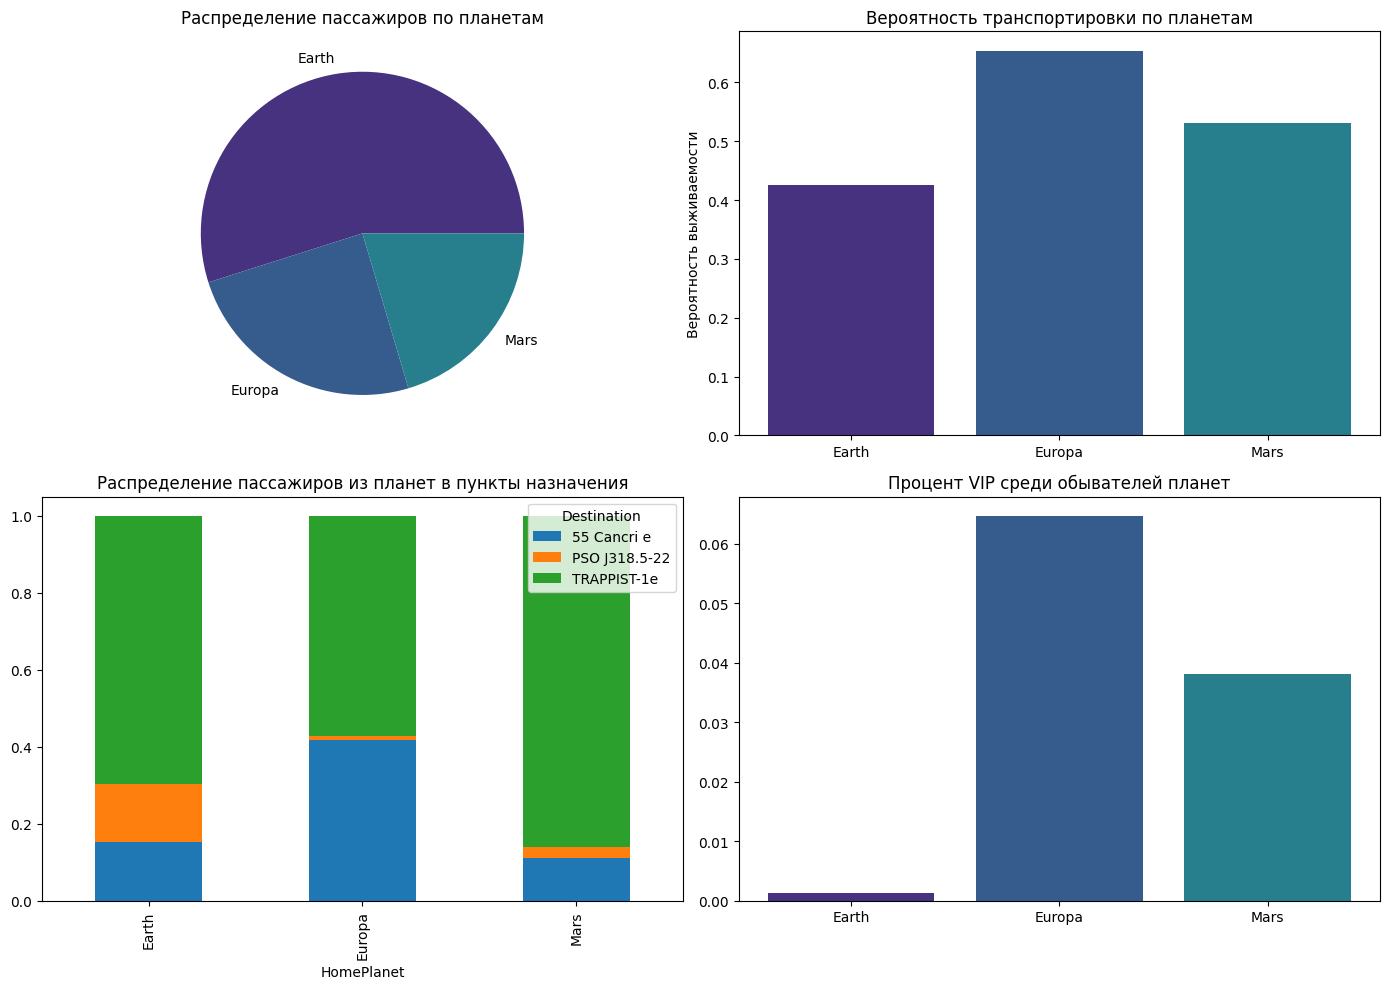

In [1330]:
#Анализ планет и телепортации
fig, axes = plt.subplots(2, 2, figsize= (14, 10))
axes[0, 0].pie(X_train['HomePlanet'].value_counts(), labels=X_train['HomePlanet'].value_counts().index, colors=sns.color_palette('viridis'))
axes[0,0].set_title('Распределение пассажиров по планетам')

tp_percent_by_planet = X_train.groupby('HomePlanet')['Transported'].mean()
axes[0,1].bar(tp_percent_by_planet.index, tp_percent_by_planet.values, color=sns.color_palette('viridis'))
axes[0,1].set_title('Вероятность транспортировки по планетам')
axes[0,1].set_ylabel('Вероятность выживаемости')

cross_tab = pd.crosstab(X_train['HomePlanet'], X_train['Destination'], normalize='index')#создает кросс таблицу между 2мя категориальными признаками, считает статистику.
cross_tab.plot(kind='bar', ax=axes[1,0], stacked=True) #stacked значит в одном столбике, а не по отдельности
axes[1, 0].set_title('Распределение пассажиров из планет в пункты назначения')

vip_percent_by_planet = X_train.groupby('HomePlanet')['VIP'].mean()
axes[1,1].bar(vip_percent_by_planet.index, vip_percent_by_planet.values, color=sns.color_palette('viridis'))
axes[1,1].set_title('Процент VIP среди обывателей планет')
plt.tight_layout()
plt.show()



In [1331]:
print(pd.pivot_table(X_train, index='HomePlanet', columns = 'Destination', values='Transported', aggfunc='mean'))
print(X_train.groupby('HomePlanet')['Transported'].mean())
#Мы должны задать себе вопрос "При данном Destination как влияет Planet, и если есть аномалия по сравнению со средним по HomePlanet, то добавляем фичу."
#Видим, что выживаемость на разных планетах в зависимости от пункта назначения разная. Например посмотрим на Earth
# выживаемость 0,50 по сравнению со средним 0,425 это неслабая аномалия.
#Но создаем фичи с осторожностью, только там, где разница со средним выше или ниже 15%
#т.е. Earth-55 Cancri e, Earth - PSO J318.5-22, Europa - PSO J318.5-22, Mars - 55 Cancri e
def planet_destination_features(X):
    X['Earth_55 Cancri e'] = ((X['HomePlanet'] == 'Earth')&(X['Destination'] == '55 Cancri e')).astype(int)
    X['Earth_PSO J318.5-22'] = ((X['HomePlanet'] == 'Earth')&(X['Destination'] == 'PSO J318.5-22')).astype(int)
    X['Europa_PSO J318.5-22'] = ((X['HomePlanet'] == 'Europa')&(X['Destination'] == 'PSO J318.5-22')).astype(int)
    X['Mars_55 Cancri e'] = ((X['HomePlanet'] == 'Mars')&(X['Destination'] == '55 Cancri e')).astype(int)

print(pd.pivot_table(X_train, index='HomePlanet', columns = 'VIP', values='Transported', aggfunc='mean'))
#Видим, что на Марсе сильно сказывается эффект VIP по выживаемости. В Европе тоже влияет, а вот на Земле эффекта вообще нет, так что
#создаем эффект только по Европе и по Марсу
def vip_effect(X):
    X['EuropaVIP'] = ((X['HomePlanet'] == 'Europa')&(X['VIP']==True)).astype(int)
    X['MarsVIP'] = ((X['HomePlanet'] == 'Mars')&(X['VIP']==True)).astype(int)

for X in all_ixes:
    planet_destination_features(X)
    vip_effect(X)


Destination  55 Cancri e  PSO J318.5-22  TRAPPIST-1e
HomePlanet                                          
Earth           0.500858       0.490468     0.395034
Europa          0.682451       0.764706     0.631365
Mars            0.622642       0.500000     0.520492
HomePlanet
Earth     0.425616
Europa    0.654048
Mars      0.531360
Name: Transported, dtype: float64
VIP            False     True 
HomePlanet                    
Earth       0.425649  0.400000
Europa      0.666252  0.477477
Mars        0.545055  0.185185


,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
RoomService,1.000000,-0.025596,0.050421,0.014706,-0.022088
FoodCourt,-0.025596,1.000000,-0.013664,0.240822,0.207715
ShoppingMall,0.050421,-0.013664,1.000000,0.014472,-0.008512
Spa,0.014706,0.240822,0.014472,1.000000,0.133320
VRDeck,-0.022088,0.207715,-0.008512,0.133320,1.000000


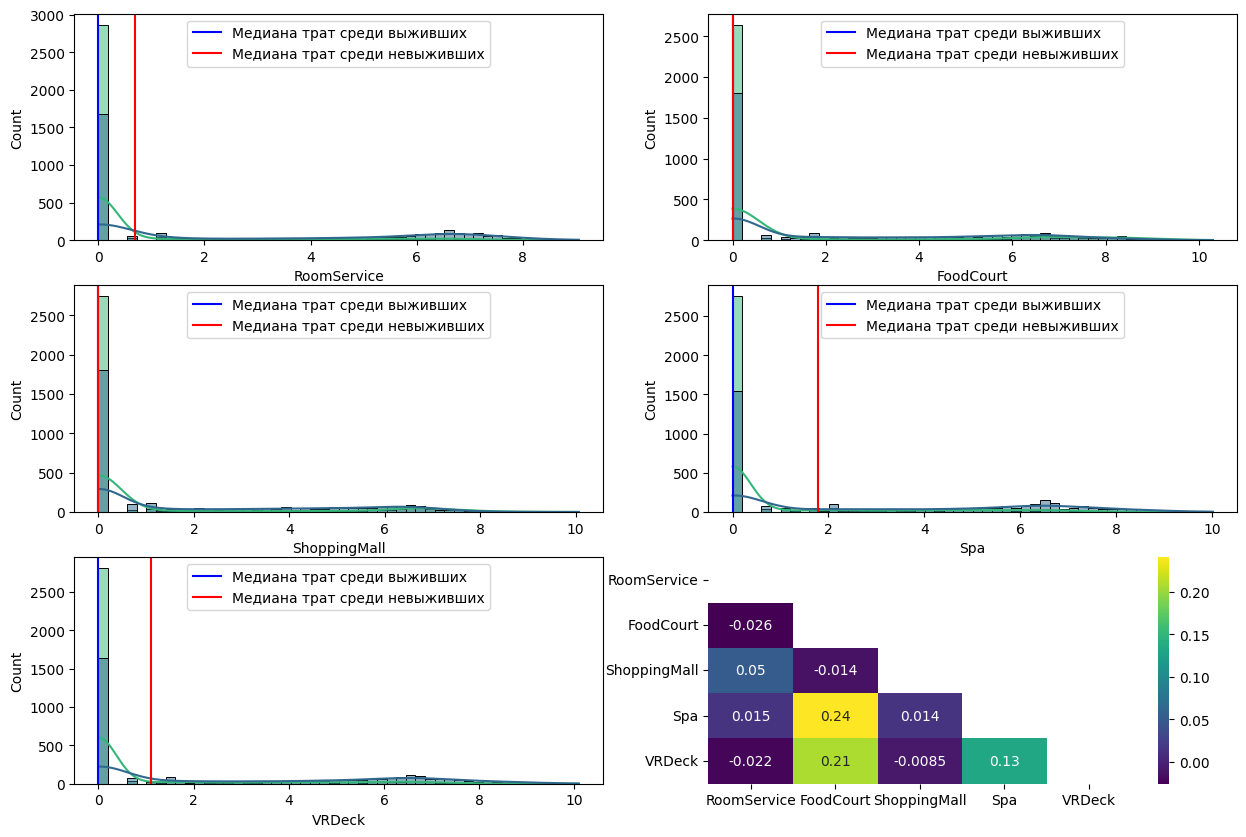

In [1332]:
#Анализ расходов
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',	'VRDeck']
fig, axes = plt.subplots(3, 2 , figsize=(15,10))
for i, col in enumerate(spending_cols):
    logged_spending = np.log1p(X_train[col].fillna(0))
    sns.histplot(data=X_train, x=logged_spending, bins=50, hue='Transported', palette='viridis', ax=axes[i//2, i%2], kde=True)
    median_transported = np.log1p(X_train[X_train['Transported']][col].median())
    median_not = np.log1p(X_train[~X_train['Transported']][col].median())
    axes[i//2, i%2].axvline(median_transported, color='blue', label='Медиана трат среди выживших')
    axes[i//2, i%2].axvline(median_not, color='red', label='Медиана трат среди невыживших')
    axes[i//2, i%2].legend(loc='upper center')

spending_corr = X_train[spending_cols].corr()
spending_corr_mask = np.triu(np.ones_like(spending_corr, dtype=bool))
sns.heatmap(data=spending_corr, mask=spending_corr_mask, annot=True, ax=axes[2, 1], cmap='viridis')
spending_corr
#По графикам видно, что чем больше люди потратили, тем больше умирали, это в каждом из графиков так, создаем суммарную фичу по всем тратам, ведь все они влияли
#По корреляции видно, что хорошо между собой коррелируют фичи FoodCourt, Spa, VRDeck - их всех в одну группу.
#Ни с кем не коррелируют RoomService, ShoppingMall. Для них создаем суммарную фичу по сумме трат, а также индивидуально создаем фичу "был ли этот сервис"


In [1333]:
#Суммарные траты
def total_spent(X):
    X['total_spent'] = X[spending_cols].sum(axis=1)
    X['log_total_spent'] = np.log1p(X['total_spent'])
#Группы по корреляциям
def corr_groups(X):
    X['correlated_group'] = X[['FoodCourt', 'Spa', 'VRDeck']].sum(axis=1)  # общественные
    X['independent_group'] = X[['RoomService', 'ShoppingMall']].sum(axis=1)  # индивидуальные
#Были ли траты по каждому типу
def has_spendings(X):
    for col in spending_cols:
        X[f'has_{col.lower()}'] = (X[col] > 0).astype(int)
#Дополнительные важные фичи
def extra_spending_features(X):
    X['spending_types_count'] = (X[spending_cols] > 0).sum(axis=1)  # сколько разных услуг
    X['any_spending'] = (X['total_spent'] > 0).astype(int)  # были ли вообще траты
for X in all_ixes:
    total_spent(X)
    corr_groups(X)
    has_spendings(X)
    extra_spending_features(X)


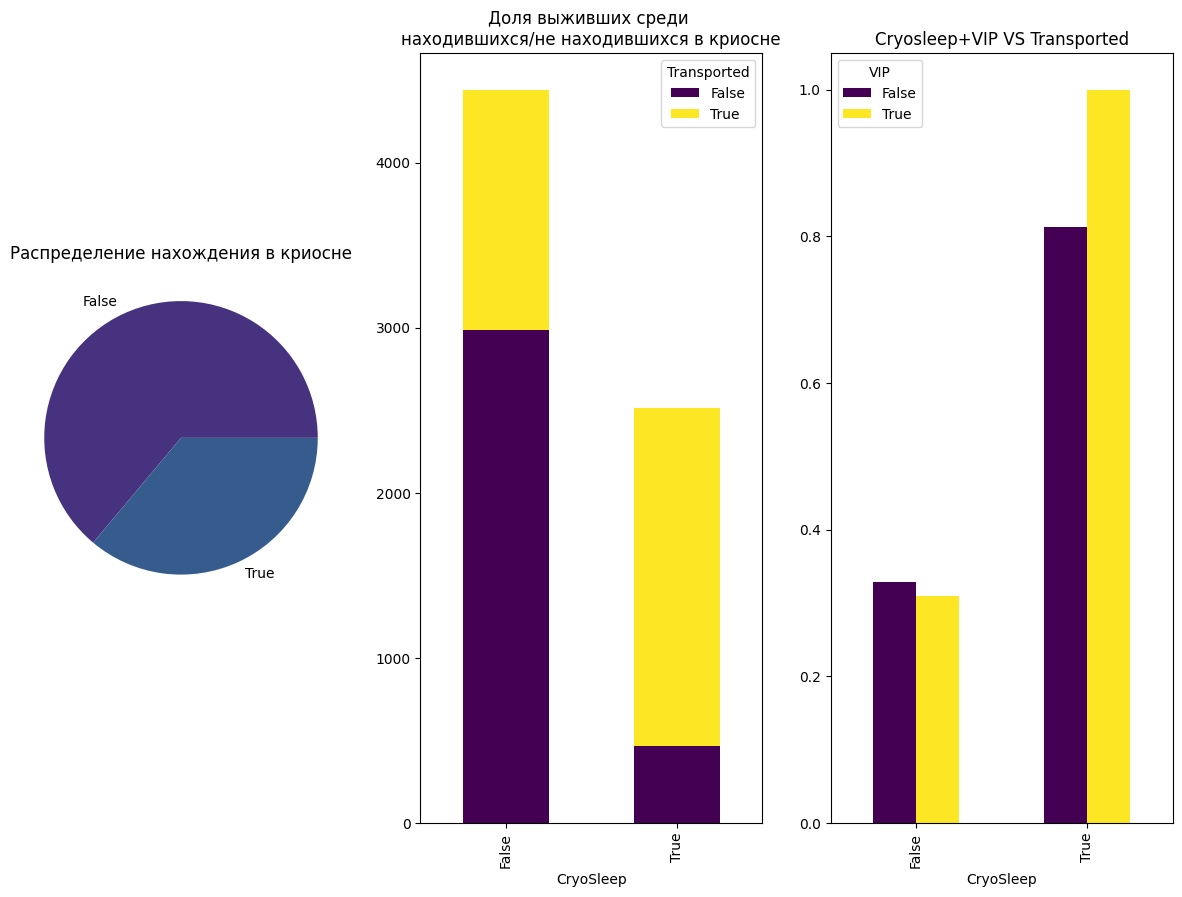

In [1334]:
#Анализ CryoSleep
fig, axes = plt.subplots(1, 3, figsize=(15,10))
X_train['CryoSleep'].value_counts()
axes[0].pie(X_train['CryoSleep'].value_counts(), labels = X_train['CryoSleep'].value_counts().index, colors=sns.color_palette('viridis'))
axes[0].set_title('Распределение нахождения в криосне')

crosstab_cryo_transp = pd.crosstab(X_train['CryoSleep'], X_train['Transported'])
crosstab_cryo_transp.plot(kind='bar', ax=axes[1], stacked=True, colormap='viridis')
axes[1].set_title('Доля выживших среди \nнаходившихся/не находившихся в криосне')

cryo_vip_transported = X_train.groupby(['CryoSleep', 'VIP'])['Transported'].mean().unstack()
cryo_vip_transported.plot(kind='bar', ax = axes[2], colormap='viridis')
axes[2].set_title('Cryosleep+VIP VS Transported')
#По графикам криосна мы видим, что доля выживших значительно выше среди тех, кто был в криосне.
#По графику Cryosleep+VIP VS Transported видно, что если ты не был в криосне, то не важно VIP ты или нет, но вот если был в криосне
#,то немного есть разница VIP ты или нет, VIP выжил больше в криосне. Создаем фичу, хотя CryoSleep и без VIP сильная фича.
def CryosleepVIP(X):
    X['CryoSleepVIP'] = ((X_train['CryoSleep'] == True)&(X_train['VIP']==True)).astype(int)
for X in all_ixes:
    CryosleepVIP(X)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'Deck', 'Side', 'group', 'Earth_55 Cancri e',
       'Earth_PSO J318.5-22', 'Europa_PSO J318.5-22', 'Mars_55 Cancri e',
       'EuropaVIP', 'MarsVIP', 'total_spent', 'log_total_spent',
       'correlated_group', 'independent_group', 'has_roomservice',
       'has_foodcourt', 'has_shoppingmall', 'has_spa', 'has_vrdeck',
       'spending_types_count', 'any_spending', 'CryoSleepVIP', 'Age < 15'],
      dtype='object')

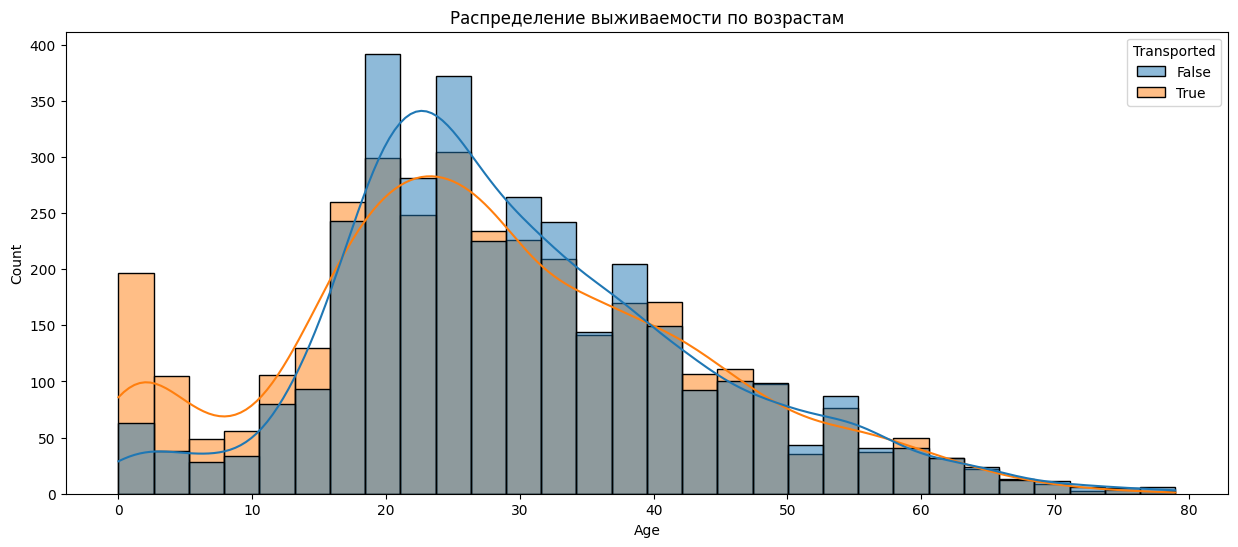

In [1335]:
#Распределение возраста
plt.figure(figsize=(15,6))
sns.histplot(data=X_train, x='Age', hue='Transported', kde=True, bins=30)
plt.title('Распределение выживаемости по возрастам')
#Видим, что дети до 15 лет выживают чаще.
X_train['Age < 15'] = (X_train['Age'] < 15).astype(int)
X_test['Age < 15'] = (X_test['Age'] < 15).astype(int)
X_to_predict['Age < 15'] = (X_to_predict['Age'] < 15).astype(int)
X_train.columns

<BarContainer object of 2 artists>

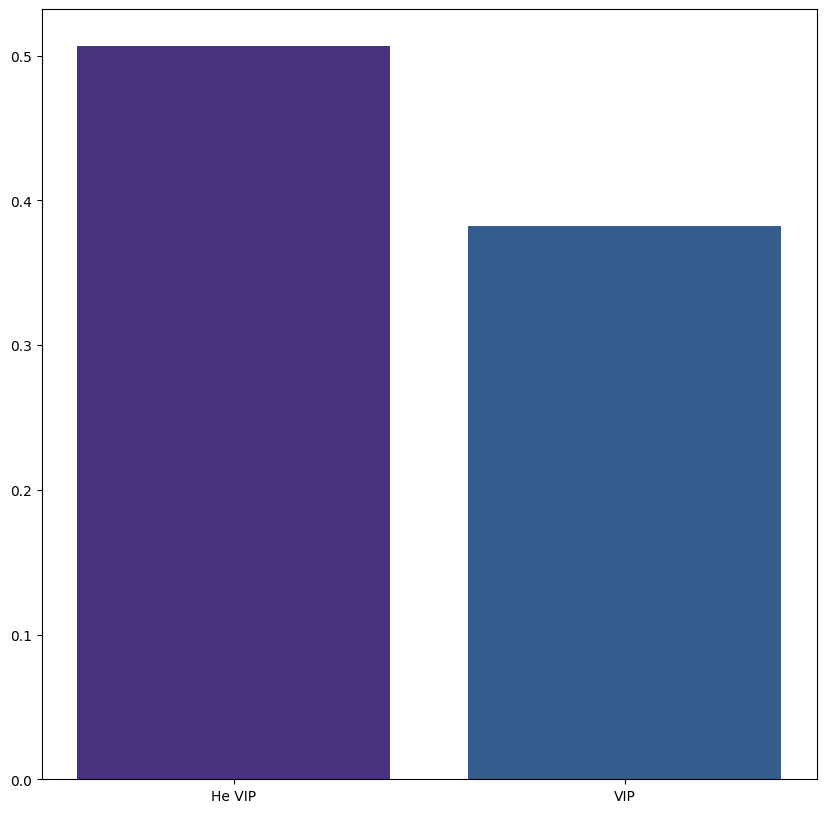

In [1336]:
#Выживаемость VIP
vip_transported = X_train.groupby('VIP')['Transported'].mean()
plt.figure(figsize=(10, 10))
plt.bar(['Не VIP', 'VIP'], vip_transported.values, color=sns.color_palette('viridis'))
#далее сделаем One-Hot фичу в пайплайне




In [1337]:
X_train.dtypes

PassengerId              object
HomePlanet               object
CryoSleep                object
Cabin                     int64
Destination              object
Age                     float64
VIP                        bool
RoomService             float64
FoodCourt               float64
ShoppingMall            float64
Spa                     float64
VRDeck                  float64
Transported                bool
Deck                     object
Side                     object
group                    object
Earth_55 Cancri e         int64
Earth_PSO J318.5-22       int64
Europa_PSO J318.5-22      int64
Mars_55 Cancri e          int64
EuropaVIP                 int64
MarsVIP                   int64
total_spent             float64
log_total_spent         float64
correlated_group        float64
independent_group       float64
has_roomservice           int64
has_foodcourt             int64
has_shoppingmall          int64
has_spa                   int64
has_vrdeck                int64
spending

C:\Users\KBA116975\AppData\Local\Temp\ipykernel_21784\3547928755.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_spent_train = X_train.groupby('age_bins')['total_spent'].median()


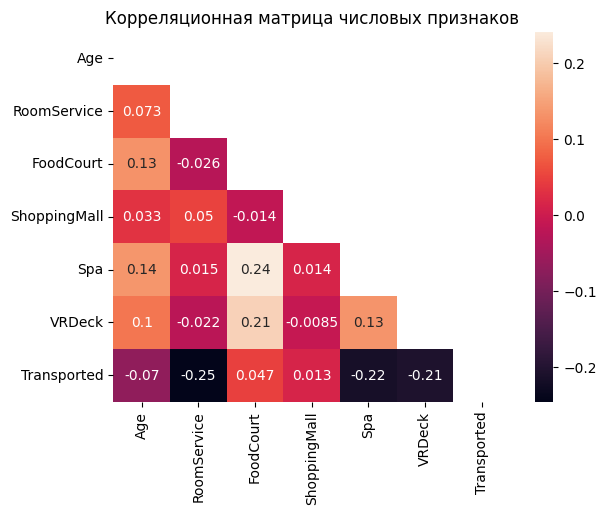

In [1338]:
#Корреляционная матрица числовых признаков
numeric_cols = X_train[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported']].columns.to_list()
numeric_corr = X_train[numeric_cols].corr()
numeric_corr_mask = np.triu(np.ones_like(numeric_corr, dtype=bool))
sns.heatmap(data=numeric_corr, mask=numeric_corr_mask, annot=True)
plt.title('Корреляционная матрица числовых признаков')
#корреляционный анализ трат мы уже видели, но мы видим, что возраст имеет положительную корреляцию с тратами
def spendings_to_age_ratio(X):
    X['spending_to_age_ratio'] = X['total_spent']/(X['Age']+1)

#Также можно найти аномалии, когда человек в своей возрастной группе тратит больше или меньше среднестатистического
# Запоминаем границы бинов из обучающей выборки
bin_edges = pd.cut(X_train['Age'], bins=10, retbins=True)[1]
X_train['age_bins'] = pd.cut(X_train['Age'], bins=bin_edges)
age_group_spent_train = X_train.groupby('age_bins')['total_spent'].median()
def spent_by_age_bins(X):
    X['age_bins'] = pd.cut(X['Age'], bins=bin_edges)
    merged = X.merge(age_group_spent_train.rename('age_group_spent'), how='left', left_on='age_bins', right_index=True)
    X['age_group_spent'] = merged['age_group_spent']
    X.drop(columns='age_bins', inplace=True)
def age_group_anomalies(X):
    X['age_group_spent_anomalies'] = (X['total_spent']>X['age_group_spent']*2).astype(int)
    X.drop(columns='age_group_spent', inplace=True)
for X in all_ixes:
    spendings_to_age_ratio(X)
    spent_by_age_bins(X)
    age_group_anomalies(X)

In [1339]:
X_train.drop(columns='Transported', inplace=True)
train_set = set(X_train.columns)
test_set = set(X_test.columns)
to_predict_set = set(X_to_predict.columns)
not_in_train = to_predict_set - test_set
not_in_train

set()

In [1340]:
#Итого по фичам:
#HomePlanet - место проживания, нужен One-Hot
#CryoSleep - был ли человек в криосне, нужен One-Hot
#Cabin - булева фича, показвающая, есть ли вообще номер кабины, возможно у бедных больше пропусков 
#Destination - пункт назначения, нужен One-Hot
#Age - возраст, оставляем как есть
#VIP - почетный или непочетный турист, превратить в int 
#'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' - траты на различные категории, оставляем как есть
#'Deck' - номер палубы. Нужен будет One-Hot
#'Side' - сторона корабля, тоже нужен будет One-hot
# group в какой группе состоял человек, будет нужен One-Hot
#Earth_55 Cancri e, Earth_PSO J318.5-22, Europa_PSO J318.5-22, Mars_55 Cancri e - логические фичи для определенных пар Destination-HomePlanet, в которых выявилась парная связь с выживаением, оставляем так
#HomePlanetVIP - эффект VIP на разных планетах сказывается по разному, комбинированная фича, нужен One-Hot
#total_spent_x, log_total_spent - сколько всего потрачено денег из разных категорий в обычном и лог масштабе, оставляем как есть
#correlated_group - траты, которые коррелировали между собой просуммировали в одну фичу
#independent_group - которые не коррелировали сумму в другую фичу
#'has_roomservice', 'has_foodcourt', 'has_shoppingmall', 'has_spa', 'has_vrdeck' - были ли вообще траты
#spending_types_count - количество трат разного типа
#any_spending - были ли вообще траты	
#Age < 15 - выживаемость детей с age<15 выше
#spending_to_age_ratio - соотношение суммы трат на возраст
#age_group_spent_anomalies - человек потратил вдвое больше среднего по возрастной группе

#VIP преобразовать в int
X_train['VIP'] = X_train['VIP'].astype(int)
X_test['VIP'] = X_test['VIP'].astype(int)
X_to_predict['VIP'] = X_to_predict['VIP'].astype(int)
X_train = X_train.set_index('PassengerId')
X_test = X_test.set_index('PassengerId')
X_to_predict = X_to_predict.set_index('PassengerId')
X_test = X_test[X_train.columns]
X_to_predict = X_to_predict[X_train.columns]
X_train.dtypes
y_train['Transported'] = y_train['Transported'].astype(int)
y_test['Transported'] = y_test['Transported'].astype(int)


In [1341]:
mi_columns = X_train.select_dtypes(['int64', 'float64']).columns.to_list()
mi = mutual_info_classif(X_train[mi_columns], y_train, random_state=1)
mi_score = pd.DataFrame({'columns': mi_columns, 'mi_score': mi}).sort_values(by='mi_score', ascending=False)
mi_score
#мы должны удалить признаки с mi_score=0




d:\Python312\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,columns,mi_score
15,log_total_spent,0.137669
27,spending_to_age_ratio,0.132451
14,total_spent,0.128795
24,any_spending,0.125462
23,spending_types_count,0.122518
16,correlated_group,0.102966
3,RoomService,0.077719
6,Spa,0.076796
17,independent_group,0.074624
21,has_spa,0.073616


In [1342]:
X_train = X_train.drop(columns=['Earth_55 Cancri e', 'CryoSleepVIP'])
X_test = X_test.drop(columns=['Earth_55 Cancri e', 'CryoSleepVIP'])
X_to_predict = X_to_predict.drop(columns=['Earth_55 Cancri e', 'CryoSleepVIP'])


In [1343]:
#В этой колонке мы будем удалять колонки, которые в дальнейших ячейках были выявлены при интерпретации моделей, как бесполезные
del_columns = ['Earth_PSO J318.5-22', 'VIP', 'Cabin', 'Mars_55 Cancri e', 'Europa_PSO J318.5-22', 'MarsVIP', 'EuropaVIP', 'has_roomservice', 'has_foodcourt', 'has_shoppingmall', 'any_spending', 'has_spa', 'has_vrdeck', 'spending_types_count', 'age_group_spent_anomalies', 'Age < 15']
X_train = X_train.drop(columns=del_columns)
X_test = X_test.drop(columns=del_columns)
X_to_predict = X_to_predict.drop(columns=del_columns)
del_columns2 = ['independent_group', 'spending_to_age_ratio', 'log_total_spent']
X_train = X_train.drop(columns=del_columns2)
X_test = X_test.drop(columns=del_columns2)
X_to_predict = X_to_predict.drop(columns=del_columns2)
X_train.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck', 'Side', 'group',
       'total_spent', 'correlated_group'],
      dtype='object')

In [1344]:
X_train.dtypes

HomePlanet           object
CryoSleep            object
Destination          object
Age                 float64
RoomService         float64
FoodCourt           float64
ShoppingMall        float64
Spa                 float64
VRDeck              float64
Deck                 object
Side                 object
group                object
total_spent         float64
correlated_group    float64
dtype: object

In [1345]:
categorical_features = X_train.select_dtypes('object').columns.tolist()
float_features = X_train.select_dtypes('float64').columns.tolist()
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
                                 ('scale', StandardScaler(), float_features)])
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', RandomForestClassifier(random_state=1))])
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', XGBClassifier(random_state=1, eval_metric='logloss'))])
param_rf = {'model__n_estimators': [5, 10, 25, 50, 100],
            'model__max_depth': [2, 5, 10, 25],
            'model__min_samples_leaf': [2, 5, 10],
            'model__class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3}]}
param_xgb = {'model__n_estimators': [5, 10, 25, 50, 100],
            'model__max_depth': [2, 5, 10, 25],
            'model__min_child_weight': [2, 5, 10],
            'model__scale_pos_weight': [1, (y_train ==0).sum()/(y_train==1).sum()],
            'model__learning_rate': [0.02, 0.04, 0.06]}
grid_search_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_rf, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)
grid_search_xgb = GridSearchCV(estimator=pipeline_xgb, param_grid=param_xgb, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)
grid_search_rf.fit(X_train, y_train)
grid_search_xgb.fit(X_train, y_train)
rf_model = grid_search_rf.best_estimator_
xgb_model = grid_search_xgb.best_estimator_
print(f'Лучшие параметры по rf : {grid_search_rf.best_params_}')
print(f'Лучшие параметры по xgb : {grid_search_xgb.best_params_}')
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
print(f'accuracy для rf - {accuracy_score(y_test, y_pred_rf)}')
print(classification_report(y_test, y_pred_rf))
print()
print(f'accuracy для xgb - {accuracy_score(y_test, y_pred_xgb)}')
print(classification_report(y_test, y_pred_xgb))
print()

Fitting 5 folds for each of 180 candidates, totalling 900 fits


d:\Python312\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Лучшие параметры по rf : {'model__class_weight': 'balanced', 'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__n_estimators': 100}
Лучшие параметры по xgb : {'model__learning_rate': 0.04, 'model__max_depth': 10, 'model__min_child_weight': 10, 'model__n_estimators': 100, 'model__scale_pos_weight': 1}
accuracy для rf - 0.7993099482461185
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       863
           1       0.79      0.82      0.80       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739


accuracy для xgb - 0.8067855089131685
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       863
           1       0.80      0.82      0.81       876

    accuracy                           0.81      1739
  

d:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
900 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
900 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Python312\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Python312\Lib\site-packages\sklearn\pipeline.py", line 663, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "d

In [1346]:
pipeline_lg = Pipeline([('preprocessor', preprocessor), ('model', LogisticRegression(random_state=1))])
param_lg = {'model__max_iter': [50, 100, 300, 1000],
            'model__penalty': ['l2', 'l1', 'elasticnet', 'none'],
            'model__C': [0.1, 0.3, 0.5, 1, 10, 100]}
grid_search_lg = GridSearchCV(estimator=pipeline_lg, param_grid=param_lg, cv=5, scoring = 'accuracy', n_jobs=-1, verbose=1)
grid_search_lg.fit(X_train, y_train)
print('Лучшие параметры для логистической регрессии:', grid_search_lg.best_params_)
lg_model = grid_search_lg.best_estimator_
y_pred_lg = lg_model.predict(X_test)
print(f'accuracy для lg - {accuracy_score(y_test, y_pred_lg)}')
print(classification_report(y_test, y_pred_lg))



Fitting 5 folds for each of 96 candidates, totalling 480 fits
Лучшие параметры для логистической регрессии: {'model__C': 1, 'model__max_iter': 50, 'model__penalty': 'l2'}
accuracy для lg - 0.7941345600920069
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       863
           1       0.79      0.81      0.80       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



d:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
360 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Python312\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Python312\Lib\site-packages\sklearn\pipeline.py", line 663, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "d:

In [1347]:
pipeline_svc = Pipeline([('preprocessor', preprocessor), ('model', SVC(random_state=1, probability=True))])
param_svc = {'model__C': [0.1, 1, 10, 100], #чем больше - тем меньше регуляризация
            'model__kernel': ['linear', 'poly', 'rbf']} 
grid_search_svc = GridSearchCV(estimator=pipeline_svc, param_grid=param_svc, cv=5, scoring = 'accuracy', n_jobs=-1, verbose=1)
grid_search_svc.fit(X_train, y_train)
print('Лучшие параметры для svc:', grid_search_svc.best_params_)
svc_model = grid_search_svc.best_estimator_
y_pred_svc = svc_model.predict(X_test)
print(f'accuracy для svc - {accuracy_score(y_test, y_pred_svc)}')
print(classification_report(y_test, y_pred_svc))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


d:\Python312\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Лучшие параметры для svc: {'model__C': 10, 'model__kernel': 'rbf'}
accuracy для svc - 0.8010350776308223
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       863
           1       0.79      0.82      0.81       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



In [1348]:
voting = VotingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model), ('lg', lg_model), ('svc', svc_model)], voting='soft')
voting.fit(X_train, y_train)
y_pred_vote = voting.predict(X_test)
print(f'accuracy для soft голосования - {accuracy_score(y_test, y_pred_vote)}')
print(classification_report(y_test, y_pred_vote))

d:\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


accuracy для soft голосования - 0.8079355951696378
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       863
           1       0.79      0.84      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



In [1349]:
X_test.isnull().sum()

HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Deck                0
Side                0
group               0
total_spent         0
correlated_group    0
dtype: int64

In [1350]:
def make_pi_score(model):
    pi = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1)
    pi_score = pd.DataFrame({'columns':X_train.columns, 'importances_mean':pi.importances_mean,
                            'importances_std': pi.importances_std}).sort_values(by='importances_mean', ascending=False)
    return pi_score
xgb_pi_score = make_pi_score(xgb_model)
rf_pi_score = make_pi_score(rf_model)
lg_pi_score = make_pi_score(lg_model)
svc_pi_score = make_pi_score(svc_model)
vote_pi_score = make_pi_score(voting)



In [1353]:
scores_dict = dict()
for pi_score in [xgb_pi_score, rf_pi_score, lg_pi_score, svc_pi_score]:
    columns = pi_score.loc[pi_score['importances_mean'] <=0, 'columns'].to_list()
    for col in columns:
        scores_dict[col] = scores_dict.get(col, 0) + 1
print(scores_dict)
#Распишем удаление вредных признаков с importance <= 0:
    #1. Для начала удалим признаки, importance, которых ниже 0, для всех моделей одновременно
        #Эффект от их удаления результатов не дал, но мы "разгрузились" от лишних признаков
del_columns = [key for key, value in scores_dict.items() if value == 4]
print(del_columns)
print(xgb_pi_score)
print(rf_pi_score)
print(lg_pi_score)
print(svc_pi_score)
print(vote_pi_score)
    #2. Признаки independent group, spending_to_age_ratio имеют отрицательный importance для лучшей модели xgb и для lg. log_total_spent <= для xgb
    #  и для rf.
        #Эффект от удаления этих признаков не повлиял на xgb, svc, но повысил rf и lg, а также повысил soft_voting, и теперь accuracy по soft_voting
        #-наивысшее.
    #3. Единственными отрицательными признаками остаются group и destination для rf, но значение невысокое, в то же время для других моделей признак имеет значительную
    #importance с положительным знаком. Не будем удалять этот признак. На этом удаление признаков завершается.



{'Destination': 1, 'group': 1}
[]
             columns  importances_mean  importances_std
12       total_spent          0.079471         0.005633
1          CryoSleep          0.067453         0.005020
5          FoodCourt          0.047096         0.004245
9               Deck          0.031167         0.003030
7                Spa          0.027487         0.003105
8             VRDeck          0.017654         0.002944
10              Side          0.016676         0.004557
4        RoomService          0.015066         0.005064
6       ShoppingMall          0.010006         0.002061
3                Age          0.008683         0.003026
0         HomePlanet          0.007821         0.002332
2        Destination          0.004600         0.002493
13  correlated_group          0.002128         0.002042
11             group          0.001955         0.001316
             columns  importances_mean  importances_std
5          FoodCourt          0.038930         0.002921
7             

In [1354]:
#Все модели дают примерно одинаковое значение accuracy, до удаления фич лучшей моделью была xgb, но после удаления в итоге принято
#решение сделать итоговой моделью soft voting.
#Переобучаем наши модели на всей выборке с train.csv. Но так можно делать только на соревнованиях, в продакшене такое недопустимо
X_train_all = pd.concat([X_train, X_test], axis=0)
y_train_all = pd.concat([y_train, y_test], axis=0)
param_rf = {k.replace('model__', ''):v for k, v in grid_search_rf.best_params_.items()}
param_xgb = {k.replace('model__', ''):v for k, v in grid_search_xgb.best_params_.items()}
param_lg = {k.replace('model__', ''):v for k, v in grid_search_lg.best_params_.items()}
param_svc = {k.replace('model__', ''):v for k, v in grid_search_svc.best_params_.items()}

rf_model_all = RandomForestClassifier(random_state=1, **param_rf)
rf_pipeline_all = Pipeline([('preprocessor', preprocessor), ('model', rf_model_all)])
rf_pipeline_all.fit(X_train_all, y_train_all)
xgb_model_all = XGBClassifier(random_state=1, eval_metric='logloss', **param_xgb)
xgb_pipeline_all = Pipeline([('preprocessor', preprocessor), ('model', xgb_model_all)])
xgb_pipeline_all.fit(X_train_all, y_train_all)
lg_model_all = LogisticRegression(random_state=1, **param_lg)
lg_pipeline_all = Pipeline([('preprocessor', preprocessor), ('model', lg_model_all)])
lg_pipeline_all.fit(X_train_all, y_train_all)
svc_model_all = SVC(random_state=1, probability=True, **param_svc)
svc_pipeline_all = Pipeline([('preprocessor', preprocessor), ('model', svc_model_all)])
svc_pipeline_all.fit(X_train_all, y_train_all)

final_voting = VotingClassifier(estimators=[('rf', rf_pipeline_all), ('xgb', xgb_pipeline_all), ('lg', lg_pipeline_all),
                                            ('svc', svc_pipeline_all)], voting='soft')
#Оставлям на всякий случай на будущее и вариант с xgboost, он тоже имеет высокое accuracy и хороший потенциал
'''param_xgb = {k.replace('model__', ''):v for k, v in grid_search_xgb.best_params_.items()}
xgb_model_all = XGBClassifier(random_state=1, eval_metric='logloss', **param_xgb)
xgb_pipeline_all = Pipeline([('preprocessor', preprocessor), ('model', xgb_model_all)])
xgb_pipeline_all.fit(X_train_all, y_train_all)
predict_to_kaggle = xgb_pipeline_all.predict(X_to_predict)'''

final_voting.fit(X_train_all, y_train_all)
predict_to_kaggle = final_voting.predict(X_to_predict)





d:\Python312\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Python312\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Python312\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

In [1355]:
submission = pd.read_csv('sample_submission.csv')
#predict_to_kaggle.to_csv('submission.csv')
submission['Transported'] = predict_to_kaggle.astype(bool)
submission.to_csv('submission.csv', index=False)